<a href="https://colab.research.google.com/github/ErnyBSB/ErnyBSB/blob/main/VisionJobFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parte I
descrição teórica


---



# 1 Descrição do problema

O problema que se busca resolver aqui é do tipo classificação, mais especificamente a classificação de imagens através de técnicas de Machine Learning. As primeiras experiências de reconhecimento de imagens através de meios cibernéticos estão entre os primeiros estudos históricos que hoje podemos chamar de Inteligência Artificial[1]. O desenvolvimento da IA teve como base os estudos sobre reconhecimento de imagens e ainda hoje é uma das áreas mais pesquisadas no ramos IA e Machine Learning. E são exemplos atuais de novas aplicações o reconhecimento facil para acesso e segurança em geral e o suporte ao funcionamento de veículos autônomos.

A classificação de imagens baseia-se na forma como este tipo de informação é capturado e armazenado (formatos de arquivo). O elemento fundamental é o pixel (correspondencia entre pontos de cor da imagem e seu código identificador de cor e posição) e cada imagem é referida pela quantidade de pixels na horizontal e vertical [2].

A técnica fundamental de classificação de imagens consiste em agrupar uma imagen baseada na disposição de seus pixels, por exemplo trata-se de uma imagem de um cão, ou de um gato. Atualmente, há várias tecnologias para classificar imagens, incluindo bibliotecas e algoritmos, desde o preparo do dataSet, o pré processamento das imagens, escolha de um modelo de Machine Learning e suas aplicações [3].

A seguir, à luz das tecnologias atuais, apresentamos a técnica escolhida aqui para classificação de imagens e detalhes sobre sua implementação.

# 2 Técnica escolhida para solução do problema

Para executar a tarefa de classificação de imagens com técnicas de Machine Learning foram previamente definidos alguns requisitos obrigatórios, como usar linguagem python e a biblioteca PyTorch. As imagens e seu repositório também foram indicados como requisitos (mais adiante abordaremos os detalhes técnicos das imagens). A especificação da tarefa prescreve três etapas:

1.   Carregamento e pre-processamento dos dados
2.   Modelagem (sem transfer learning)
1.   Visualizações e avaliação

Desta forma resta-nos opções específicas de código, como escolha do modelo específico e escolha de parâmetros (serão detalhados adiante).

### Sobre o conjunto de imagens utilizado (DataSet)

Como especificação do projeto, a tarefa consiste em "classificar, a partir de imagens multiespectrais de satélite, o uso/cobertura do solo que está sendo representada". O dataset definido é o EuroSAT, utilizamos a versão disponível no repositório Kaggle [4]. Inicialmente, tentamos utilizar a codificação da tarefa diretamente em um NoteBook do Kaggle, mas atualmente é disponibilizado o recurso de execução em um Google Colab, importando o DataSet com download em cache diretamente no Colab. De forma que optamos por esta estratégia, pois o Colab permite o uso de GPU's de maneira facilitada.

As imagens do DataSet EuroSAT estão no padrão RGB, o que significa que cada pixel de uma imagem digital é composto por uma das três cores básicas: vermelho, verde e azul.[5]. Esta informação é importante nos passos seguintes de codificação do processamento das imagens, além também do número de pixels que cada imagem possui, que no caso é 64x64 pixels e imagens no formato .jpg.

Além das imagens em si, o dataset EuroSAT também possui os labels (etiquetas) das imagens, ou seja, a identificação do grupo ao qual a imagem pertence, ou sua classe. Neste dataset, as imagens podem pertencer a 10 classes diferentes:


---


AnnualCrop

Forest

HerbaceousVegatation

Highway

Industrial

Pasture

PermanentCrop

Residential

River

SeaLake


---


Notar que sempre se referem a opções geoespaciais como floresta (forest), ou rio (River). A tarefa de classificação portanto é identificar qual grupo cada imagem pertence. É claro que no caso deste dataset todas as imagens já foram identificadas para treinamento de um modelo que se adequadamente treinado deve ser capaz de identificar a classe de outras imagens fora do contexto do dataset.

Para o treinamento, são disponibilizados arquivos no formato .CSV com três colunas (Filename,Label,ClassName), ou seja, o nome do arquivo .jpg, o label numérico da classe e o nome da classe.

Os arquivos .CSV são disponibilizados em três categorias: train, validation e teste. Ou seja, a relação de imagens e labels para treinamento do modelo, para validação do modelo treinado e para testes finais (vide discussão na descrição detalhada da solução).

A organização dos lotes de treinamento, validação e testes do dataSet EuroSAT é a seguinte (escolhida por seu criador):


---


Tamanho do conjunto de dados: 27.000 imagens;

Treinamento: Cerca de 19.000 imagens;

Validação/Teste: Cerca de 8.000 imagens;


---


Um ponto interessante aqui é a escolha de quais imagens estão em cada arquivo .CSV, sabemos que as imagens são numeradas e não estão em ordem numérica, a escolha de quantas imagens de quantas classes também foi aleatória, qual a importância disto? Adotar e usar os conjuntos originais de treino, validação e testes permite a reprodução do mesmo experimento por outras pessoas. Do contrário, diferentes implementações conseguiriam diferentes resultados de precisão por exemplo. Alguns datasets disponibilizam um único arquivo e cabe a cada implementador fazer a divisão entre os conjuntos de treino, validação e testes, mas isto aumenta a probabilidade de obter diferentes resultados, ainda que a técnica de "seed" possa mitigar isto.

Com estas informações, podemos fazer a análise da implementação e seus detalhes para as três etapas acima descritas.



# 3 Detalhes da implementação e experimentos

O desenvolvimento do código na parte II deste projeto está dividido em 5 etapas:

1.   Importações de dados e bibliotecas principais
2.   Definição dos conjuntos de treino, validação e testes
1.   Arquitetura e Inicialização do Modelo
2.   Loops de Treinamento
1.   Avaliação do Modelo no conjunto de testes

A **primeira etapa** apenas reflete a opção de utilizar um dataset hospedado no kaggle e sua importação e download em cache neste colab. E reflete também a opção de utilizar bibliotecas pyTorch, PIL para imagens (poderia ser cv2), sklearn para métricas, pandas e numpy para dataframes. A colocação de todas as bibliotecas utilizadas no início do código é uma preferência pessoal minha.

Na **etapa 2** são criados os dataframes train_df, val_df e test_df a partir dos arquivos .CSV disponibilizados pelo dataset. Os demais tratamentos nas imagens e labels serão feitos a partir destes dataframes.

A parte mais relevante na etapa 2 é o pré processamento com "transforms" para criar os "loaders" utilizados no treinamento do modelo (train_loader), na validação do treino (val_loader) e nos testes (test_loader).

```
import torchvision.transforms as transforms
```

A classe transforms [6] é bastante utilizada para processamento de imagens e preparo para treinamento de modelos de Machine Learning.

A classe pode ser utilizada para efetuar "transformações" nos arquivos das imagens antes do treino do modelo. Como por exemplo "Data Augmentation" (aumentar artificialmente o tamanho e a variabilidade do conjunto de dados), "Conversão" das imagens para um formato compatível com a rede neural, ou "Normalização" (ajuste dos pixels para uma faixa que pode melhorar a convergência) [7]. Estas transformações aqui tem o objetivo de "aproximar" as imagens do "mundo real" onde nada é em dois planos a partir de um mesmo ângulo. A transformação jitter por exemplo pode de certa forma simular uma foto "mal tirada". Espera-se com isto que estes "desafios" ao treinamento, com imagens transformadas, podem gerar um modelo mais robusto no reconhecimento de imagens em geral

No código elaborado ela é utilizada juntamente com a classe Compose, que permite uma espécie de encadeamento de transformações (transforms) em sequência.

Para o conjunto de treinamento, utilizamos as seguintes transformações: RandomResizeCrop, RandomHorizontalFlip, ToTensor e Normalize. [7]

```
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
```

Nos testes, também treinamos com RandomRotation, ColorJitter e RandomVerticaFlip, mas o treinamento ficou mais lento, sem benefícios em termos de acurácia por exemplo.

O mesmo procedimento também foi aplicado ao conjunto de validação do treinamento. Notar que o conjunto de testes não é "transformado", pois pressume-se um teste como se fossem imagens reais para o modelo treinado.

Em seguida são criados os "loaders" para treino, validação e teste do modelo. Para criá-los uma função (EuroSATDataset()) conecta os dataframes importados diretamente dos arquivos .CSV com o diretório onde estão as imagens e as transformações já executadas (figura código acima).

```
train_dataset = EuroSATDataset(train_df, data_dir, transform=train_transforms)
val_dataset = EuroSATDataset(val_df, data_dir, transform=val_test_transforms)
test_dataset = EuroSATDataset(test_df, data_dir, transform=val_test_transforms)
```
A partir dos objetos DataSet [8] (train_dataset, val_dataset e test_dataset) o objeto DataLoader permite uma série de ações, no caso específico aqui utilizamos "batching" e "shuffling":

```
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
```

Estes últimos objetos serão utilizados mais adiante no Loop de Treinamento.

A próxima etapa do projeto é Arquitetura e Inicialização do Modelo, etapa 3.

Para definir a arquitetura da rede neste projeto foi utilizada a classe torch.nn [9]. Através desta classe são definidas as camadas dos modelos e suas características, como o uso de camada convolucional (importante para treinamento de imagens) nn.Conv2s, camadas de pooling nn.MaxPool2d, ou normalização de batch (recurso não utilizado aqui). As funções de ativação e perda também são escolhidas nos parâmetros desta classe.

Inserimos comentários intensivamente, praticamente linha a linha do código abaixo.


```
class CNN(nn.Module):
    def __init__(self, num_classes=10): # construtor das camadas do Modelo
        super(CNN, self).__init__()
        # ----------------------- ESPECIFICAÇÃO DAS CAMADAS: três camadas com RelU e Max Pooling
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # primeira camada: 3 canais de entrada (RGB), 16 canais de saída, 3x3 kernel, 1 pixel padding
        self.relu1 = nn.ReLU() # ativação com a função ReLU
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # camada tipo Max pooling layer com kernel 2x2 e stride 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # segunda camada: 16 canais de entrada, 32 canais de saída, 3x3 kernel, 1 pixel padding
        self.relu2 = nn.ReLU() # ativação com a função ReLU, novamente
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # camada tipo Max pooling layer com kernel 2x2 e stride 2, novamente
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # terceira camada: 32 canais de entrada, 64 canais de saída, 3x3 kernel, 1 pixel padding
        self.relu3 = nn.ReLU() # ativação com a função ReLU, novamente
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # camada tipo Max pooling layer com kernel 2x2 e stride 2, novamente
        # -------------------------- camada pré saída
        self.fc1 = nn.Linear(64 * 28 * 28, 128) # camada totalmente conectada: entrada calculada com base no mapa de tamanho
        self.relu4 = nn.ReLU() # ativação com a função ReLU, novamente
        # -------------------------- camada saída
        self.fc2 = nn.Linear(128, num_classes) # 10 classes na saída final

    def forward(self, x): # DEFINIÇÃO DOS PASSOS PRA FRENTE:
        x = self.pool1(self.relu1(self.conv1(x))) # passo de entrada pela primeira camada
        x = self.pool2(self.relu2(self.conv2(x))) # passo de entrada pela segunda camada
        x = self.pool3(self.relu3(self.conv3(x))) # passo de entrada pela terceira camada
        # --------------------------------
        x = x.view(-1, 64 * 28 * 28) # achata a saída da pré camada de saída
        x = self.relu4(self.fc1(x)) # passa a saída da pré camada pela camada relu4
        x = self.fc2(x) # passa a saída pela camada final
        return x
```

O código acima foi o melhor resultado que conseguimos com vários testes, mudando no número e especificação de camadas. A função de ativação Relu é uma opção clássica.

Na inicialização do modelo com a arquitetura escolhida também utilizamos função de perda e otimizador clássicas:

```
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
```
Os resultados obtidos ficaram dentro do esperado, então não fizemos testes com outras opções neste trecho. Talvez com o uso de algum método automático de busca de parâmetros esta tarefa poderia ser executada também.

Após a inicialização do modelo com as dez classes do dataSet,

```
model = CNN(num_classes=10).to(device)
```
Pode-se executar o loop de treinamento.

Tudo que foi feito anteriormente foi uma preparação de parâmetros para executar o treinamento do modelo a partir dos DataLoaders (train_loader) do dataset EuroSAT, bem como a validação do treino (val_loader).

Dividimos a análise do Loop de treinamento em duas partes, o treinamento em si (model.train()) e a sua validação (model.eval()) com o DataLoader de validação.

O código está estruturado num "for" externo (que itera sobre o número de épocas especificado, 30). Testamos diferentes números de epocas, mas com o "early stopping" é foi um número adequado. O "for" interno itera sobre o "train_loader". As imagens e labels são enviados para processamento na GPU (utilizamos uma T4 com RAM alta). São obtidos os "outputs" com as previsões, o erro é calculado (loss = criterion(outputs, labels) e o processo de "backpropagtion" ocorre. A cada 100 passos o resultado é impresso. Comentamos praticamente todas as linhas.

```
    model.train()  # Define o modelo para modo de treinamento
    for i, (images, labels) in enumerate(train_loader): # retorna index i, images e labels
        images = images.to(device) # move os dados para a GPU
        labels = labels.to(device) # move os labels para a GPU

        outputs = model(images) # passa as images para o modelo obter predições
        loss = criterion(outputs, labels) # calcula a perda

        optimizer.zero_grad() # zera os gradientes antes de novo passo
        loss.backward() # computa os gradientes usando backpropagation
        optimizer.step() # atualiza os parâmetros do otimizador e calcula gradientes

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

```
Já a parte II do loop itera sobre o objeto (val_loader), o cálculo dos gradientes é temporariamente desabilitado e as previsões métricas podem então ser calculadas.



```
    model.eval()  # Define o modelo para modo de avaliação (val_loader)
    all_predictions = []
    all_labels = []
    correct = 0
    total = 0
    with torch.no_grad():  # Desabilita o cálculo de gradientes durante a validação
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
```

Adicionalmente, acrescentamos no código o cálculo de acurácia, precisão, recall e F1-Score (sciKit-learn) para um melhor acompanhamento do processo.

Como aprimoramento, também acrescentamos o recurso de "early stopping". Chegamos a testar também uma versão do código com "learning rate scheduling", mas o resultado foi melhor com a solução atual.

A última etapa da codificação é a 5, Avaliação do modelo com o DataLoader de testes (test_loader). E o código aqui é bem simples, o modelo entra em modo de avaliação (model.eval()), os gradientes são desligados e um loop "for" é executado no objeto test_loader. As previsões são comparadas com as saídas (outputs) e o resultado final é impresso.



```
model.eval()  # Define o modelo para o modo de avaliação
with torch.no_grad():  # Desativa o cálculo do gradiente
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Acurácia do Modelo no conjunto de testes: {100 * correct / total}%')
```



# 4 Apresentação e análise crítica

O melhor resultado de treinamento do modelo ocorreu com 26 épocas, interrompido pelo mecanismo de "early stopping".

```
Epoch [26/30], Step [100/591], Loss: 0.6101
Epoch [26/30], Step [200/591], Loss: 0.2957
Epoch [26/30], Step [300/591], Loss: 0.4142
Epoch [26/30], Step [400/591], Loss: 0.4936
Epoch [26/30], Step [500/591], Loss: 0.3020
--------------------------------------------------------------------------
Epoch [26/30], Validation Accuracy: 89.76%
Epoch [26/30], Validation Precision: 0.90
Epoch [26/30], Validation Recall: 0.89
Epoch [26/30], Validation F1-score: 0.89
```

Na avaliação com o conjunto de testes a acurácia foi:

```
Acurácia do Modelo no conjunto de testes: 89.81481481481481%
```

A confusion matrix apresentou resultados dentro do esperado (vide gráfico na última seção)

Do ponto de vista do treinamento do modelo a acurácia máxima obtive é bem interessante. Alterações na arquitetura do modelo, como o número de camadas, testes com outras funções de ativação, ou diferentes transformações poderiam alterar este valor para cima, mas também para baixo. Considerando o objetivo didático do projeto, consideramos este valor adequado.

O trecho de código mais desafiador foi sem dúvida a construção do Loop de Treinamento. A codificação ocorreu em camadas, primeiro os loops "for" para treinamento em si. Depois acrescentamos os recursos de acompanhamento com "print" (acurácia e etc.), a codificação "early stopping" e finalmente as plotagens gráficas da relação de diminuição da perda em função das épocas de treinamento. Todas estas etapas foram (re)escritas pelo menos umas vinte vezes até o resultado final aqui apresentado.

Do ponto de vista de estruturação do código e desenvolvimento do projeto, estamos bastante satisfeitos com o resultado apresentado, pois o código nos parece bastante claro, bem comentado e bem organizado para compreensão de qualquer outro programador que se interesse pelo resultado, bem como a performance do modelo dentro de valores aceitáveis.


# 5 Conclusão

Com a profusão de conhecimentos e facilitado de intermediadores como LLMs, repositórios como o Kaggle e ferramentas como o Colab que também possui um bom assistente de código com IA, o desenvolvimento deste projeto foi de dificuldade baixa. Além disso a especificação do projeto já definiu boa parte do caminho que deveria ser percorrido.

O assunto Visão Computacional, Image Recognition e Image Classification não é nosso maior interesse de pesquisa, mas é um assunto bastante maduro na área de IA e boa parte das disciplinas da Pós Graduação utilizada exemplos para processamento de imagens. É também uma maneira bastante concreta de iniciação no universo de Machine Learning.

A fonte dos diferentes snippets de código foram vários NoteBooks Colab ao longo deste curso. De fato, coincidentemente, a primeira aula da última disciplina deste curso (Laboratório), foi justamente a análise de um Pipeline para tratamento de imagens. Como já mencionamos, o treinamento de imagens foi abordado em várias disciplinas e datasets, como o CIFAR10 (objeto de um trabalho final de disciplina). Códigos e revisões de códigos foram obtidos com prompts de modelos na API Gemini e openAI, aproveitamos o exercício para tentar vários modelos como o oMini, gpt4, 1.5 Pro, 2.0 Flash.

Acredito que produzimos o código com equilíbrio entre outros códigos utilizados no curso e apoio de LLMs para revisão.

É interessante como as próprias ferramentas de IA, como as citadas acima, podem ser utilizadas para produzir novos modelos e recursos de IA, num ciclo virtuoso de conhecimento e aprimoramento.

# Referências

1. WIKIPEDIA. Computer vision. Disponível em: <https://en.wikipedia.org/wiki/Computer_vision#Recognition>. Acesso em: 25 de janeiro de 2025.

2. IMAGE classification based deep learning: A review. Disponível em: <https://journals.ekb.eg/article_259887_6a845476900a610fcdfda6b0b0120a08.pdf>. Acesso em: 25 de janeiro de 2025.


3. RESEARCHGATE. A review of image classification approaches and techniques. Disponível em: <https://www.researchgate.net/publication/339662419_A_Review_of_Image_Classification_Approaches_and_Techniques>. Acesso em: 25 de janeiro de 2025.


4. KAGGLE. EuroSAT dataset. Disponível em: <https://www.kaggle.com/datasets/apollo2506/eurosat-dataset>. Acesso em: 25 de janeiro de 2025.


5. WIKIPEDIA. RGB. Disponível em: <https://pt.wikipedia.org/wiki/RGB>. Acesso em: [25 de janeiro de 2025.


6. PYTORCH. Transforms. Disponível em: <https://pytorch.org/vision/0.9/transforms.html>. Acesso em: 25 de janeiro de 2025.


7. CODER IN AUSTRIA. Using the class-transformer for better data architecture. Medium. Disponível em: <https://medium.com/@coder_in_austria/using-the-class-transformer-for-better-data-architecture-87448f74037a>. Acesso em: 25 de janeiro de 2025.


8. PYTORCH. Datasets & DataLoaders. Disponível em: <https://pytorch.org/tutorials/beginner/basics/data_tutorial.html>. Acesso em: 25 de janeiro de 2025.


9. PYTORCH. torch.nn. Disponível em: <https://pytorch.org/docs/stable/nn.html>. Acesso em: 25 de janeiro de 2025.



















# Parte II

desenvolvimento de código

---



# 1 Importações de dados e bibliotecas principais

In [ ]:
#@title Importando do Kaggle
"""
Download para o cache, repetir a importação a cada nova execução.
"""

import kagglehub
apollo2506_eurosat_dataset_path = kagglehub.dataset_download('apollo2506/eurosat-dataset')

print('Data source import complete.')


100%|██████████| 2.04G/2.04G [00:13<00:00, 157MB/s]

Extracting files...


Data source import complete.


In [ ]:
#@title Caminho para o data_dir

print(apollo2506_eurosat_dataset_path)
!ls -l $apollo2506_eurosat_dataset_path

/root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6
total 8
drwxr-xr-x 12 root root 4096 Jan 26 21:13 EuroSAT
drwxr-xr-x 12 root root 4096 Jan 26 21:13 EuroSATallBands


In [ ]:
data_dir = '/root/.cache/kagglehub/datasets/apollo2506/eurosat-dataset/versions/6' + '/EuroSAT'

In [ ]:
#@title Bibliotecas Principais

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
#---------------------------------------------------
from torch.utils.data import Dataset
from PIL import Image
#---------------------------------------------------
from sklearn.metrics import precision_score, recall_score, f1_score
#---------------------------------------------------
import seaborn as sns
from sklearn.metrics import confusion_matrix
#---------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


# 2 Definição dos conjuntos de treino, validação e testes

In [ ]:
#Importando treinamento, validação e teste

train_df = pd.read_csv(data_dir + '/train.csv')
val_df = pd.read_csv(data_dir + '/validation.csv')
test_df = pd.read_csv(data_dir + '/test.csv')

In [ ]:
#Organizando o DataSet em treinamento, validação e testes

"""
função EuroSATDataset() é uma classe que herda de torch.utils e tem como objetivo
criar os dataset para treinamento, validação e teste.
"""

class EuroSATDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.at[idx, 'Filename'])  # coluna nome do arquivo
        image = Image.open(img_name).convert('RGB')
        label = self.df.at[idx, 'Label']  # coluna label da imagem

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
#Transformações para o conjunto de treinamento

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
#Transformações para os conjuntos de validação e teste
val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
#Criar os grupos de treino, validação e teste

# Criar os datasets
train_dataset = EuroSATDataset(train_df, data_dir, transform=train_transforms)
val_dataset = EuroSATDataset(val_df, data_dir, transform=val_test_transforms)
test_dataset = EuroSATDataset(test_df, data_dir, transform=val_test_transforms)

# Criar DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# 3 Arquitetura e Inicialização do Modelo

In [ ]:
#@title Arquitetura da rede
class CNN(nn.Module):
    def __init__(self, num_classes=10): # construtor das camadas do Modelo
        super(CNN, self).__init__()
        # ----------------------- ESPECIFICAÇÃO DAS CAMADAS: três camadas com RelU e Max Pooling
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # primeira camada: 3 canais de entrada (RGB), 16 canais de saída, 3x3 kernel, 1 pixel padding
        self.relu1 = nn.ReLU() # ativação com a função ReLU
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # camada tipo Max pooling layer com kernel 2x2 e stride 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # segunda camada: 16 canais de entrada, 32 canais de saída, 3x3 kernel, 1 pixel padding
        self.relu2 = nn.ReLU() # ativação com a função ReLU, novamente
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # camada tipo Max pooling layer com kernel 2x2 e stride 2, novamente
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # terceira camada: 32 canais de entrada, 64 canais de saída, 3x3 kernel, 1 pixel padding
        self.relu3 = nn.ReLU() # ativação com a função ReLU, novamente
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # camada tipo Max pooling layer com kernel 2x2 e stride 2, novamente
        # -------------------------- camada pré saída
        self.fc1 = nn.Linear(64 * 28 * 28, 128) # camada totalmente conectada: entrada calculada com base no mapa de tamanho
        self.relu4 = nn.ReLU() # ativação com a função ReLU, novamente
        # -------------------------- camada saída
        self.fc2 = nn.Linear(128, num_classes) # 10 classes na saída final

    def forward(self, x): # como os dados de entrada fluem pelas camadas:
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        # --------------------------------
        x = x.view(-1, 64 * 28 * 28) # achata a saída da pré camada de saída
        x = self.relu4(self.fc1(x)) # passa a saída da pré camada pela camada relu4
        x = self.fc2(x) # passa a saída pela camada final
        return x

In [ ]:
#@title Inicialização do Modelo e seus parâmetros

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4 Loops de Treinamento

Epoch [1/30], Step [100/591], Loss: 1.5370
Epoch [1/30], Step [200/591], Loss: 1.0284
Epoch [1/30], Step [300/591], Loss: 0.8861
Epoch [1/30], Step [400/591], Loss: 0.8992
Epoch [1/30], Step [500/591], Loss: 0.6275
--------------------------------------------------------------------------
Epoch [1/30], Validation Accuracy: 71.96%
Epoch [1/30], Validation Precision: 0.71
Epoch [1/30], Validation Recall: 0.72
Epoch [1/30], Validation F1-score: 0.71


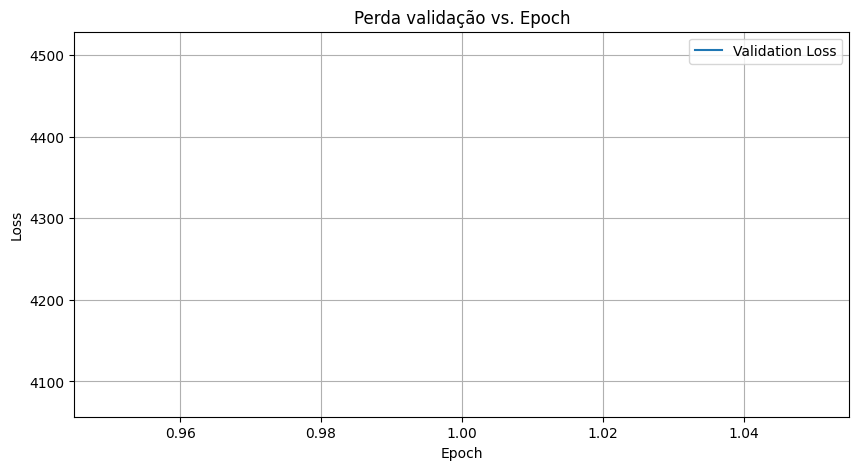

Epoch [2/30], Step [100/591], Loss: 1.1233
Epoch [2/30], Step [200/591], Loss: 0.6888
Epoch [2/30], Step [300/591], Loss: 0.8573
Epoch [2/30], Step [400/591], Loss: 1.1197
Epoch [2/30], Step [500/591], Loss: 0.6498
--------------------------------------------------------------------------
Epoch [2/30], Validation Accuracy: 75.17%
Epoch [2/30], Validation Precision: 0.76
Epoch [2/30], Validation Recall: 0.75
Epoch [2/30], Validation F1-score: 0.74


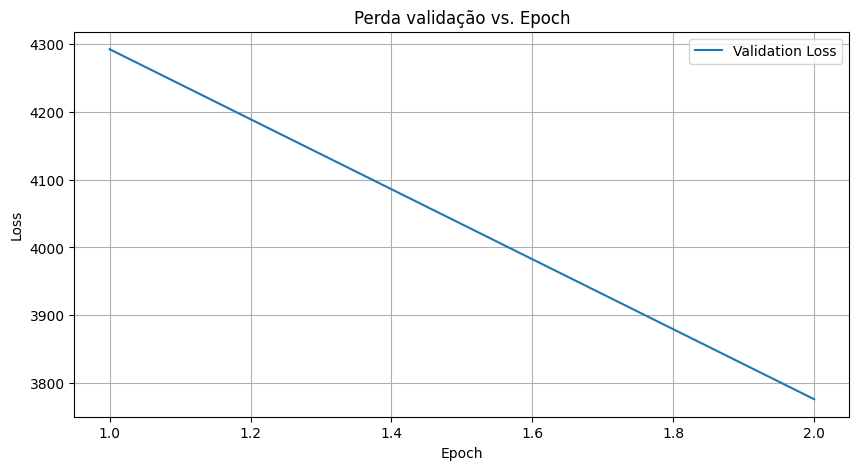

Epoch [3/30], Step [100/591], Loss: 0.6513
Epoch [3/30], Step [200/591], Loss: 0.7552
Epoch [3/30], Step [300/591], Loss: 0.6931
Epoch [3/30], Step [400/591], Loss: 0.9675
Epoch [3/30], Step [500/591], Loss: 0.6903
--------------------------------------------------------------------------
Epoch [3/30], Validation Accuracy: 73.89%
Epoch [3/30], Validation Precision: 0.76
Epoch [3/30], Validation Recall: 0.73
Epoch [3/30], Validation F1-score: 0.73


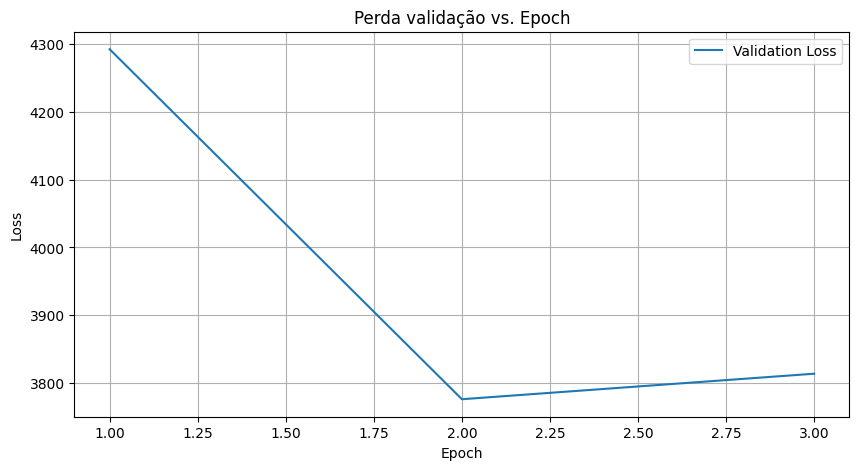

Epoch [4/30], Step [100/591], Loss: 0.9093
Epoch [4/30], Step [200/591], Loss: 0.8743
Epoch [4/30], Step [300/591], Loss: 0.9133
Epoch [4/30], Step [400/591], Loss: 0.5126
Epoch [4/30], Step [500/591], Loss: 0.8732
--------------------------------------------------------------------------
Epoch [4/30], Validation Accuracy: 76.98%
Epoch [4/30], Validation Precision: 0.78
Epoch [4/30], Validation Recall: 0.77
Epoch [4/30], Validation F1-score: 0.76


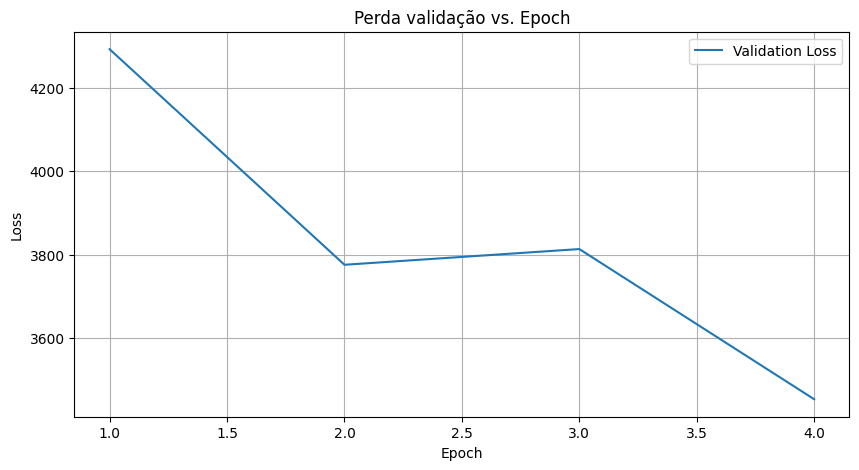

Epoch [5/30], Step [100/591], Loss: 0.9807
Epoch [5/30], Step [200/591], Loss: 0.4657
Epoch [5/30], Step [300/591], Loss: 0.6260
Epoch [5/30], Step [400/591], Loss: 0.5938
Epoch [5/30], Step [500/591], Loss: 0.5244
--------------------------------------------------------------------------
Epoch [5/30], Validation Accuracy: 81.22%
Epoch [5/30], Validation Precision: 0.81
Epoch [5/30], Validation Recall: 0.81
Epoch [5/30], Validation F1-score: 0.81


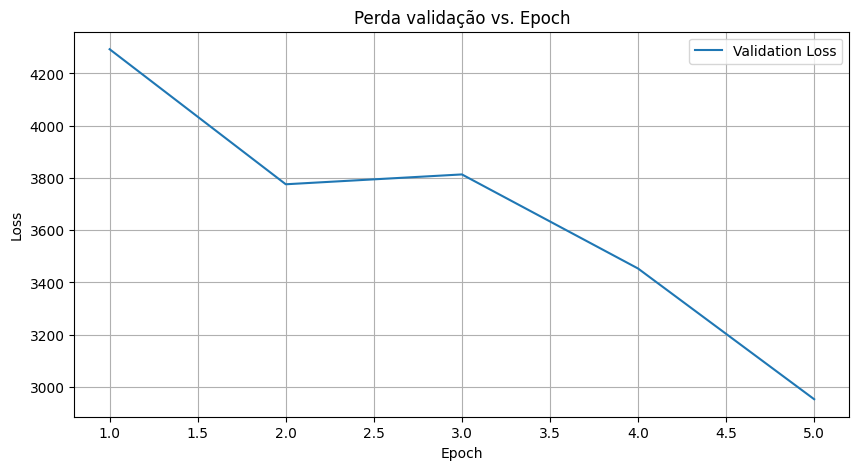

Epoch [6/30], Step [100/591], Loss: 0.8418
Epoch [6/30], Step [200/591], Loss: 0.6750
Epoch [6/30], Step [300/591], Loss: 0.7590
Epoch [6/30], Step [400/591], Loss: 0.5931
Epoch [6/30], Step [500/591], Loss: 0.6434
--------------------------------------------------------------------------
Epoch [6/30], Validation Accuracy: 81.44%
Epoch [6/30], Validation Precision: 0.81
Epoch [6/30], Validation Recall: 0.81
Epoch [6/30], Validation F1-score: 0.81


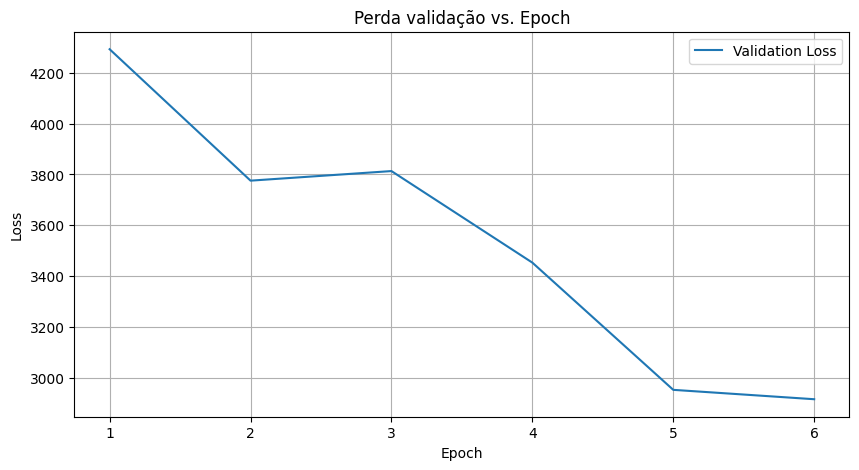

Epoch [7/30], Step [100/591], Loss: 0.3915
Epoch [7/30], Step [200/591], Loss: 0.6623
Epoch [7/30], Step [300/591], Loss: 0.4477
Epoch [7/30], Step [400/591], Loss: 0.8200
Epoch [7/30], Step [500/591], Loss: 0.4809
--------------------------------------------------------------------------
Epoch [7/30], Validation Accuracy: 79.22%
Epoch [7/30], Validation Precision: 0.80
Epoch [7/30], Validation Recall: 0.79
Epoch [7/30], Validation F1-score: 0.79


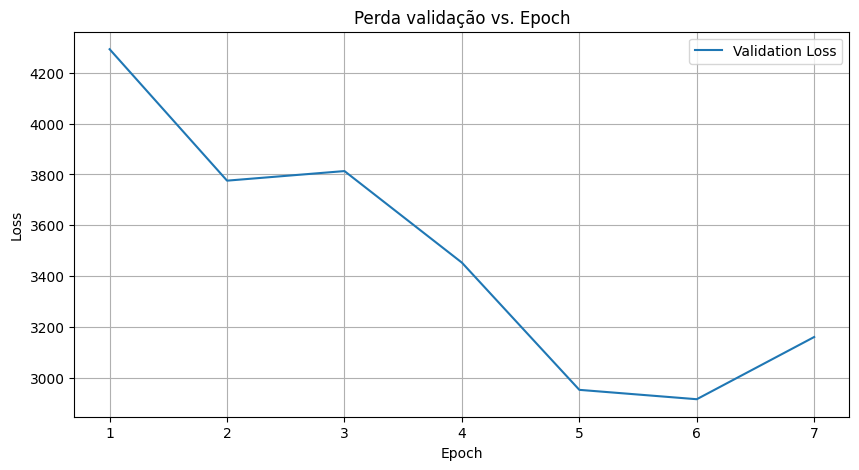

Epoch [8/30], Step [100/591], Loss: 0.6567
Epoch [8/30], Step [200/591], Loss: 0.5355
Epoch [8/30], Step [300/591], Loss: 0.4629
Epoch [8/30], Step [400/591], Loss: 0.7468
Epoch [8/30], Step [500/591], Loss: 0.3236
--------------------------------------------------------------------------
Epoch [8/30], Validation Accuracy: 82.24%
Epoch [8/30], Validation Precision: 0.83
Epoch [8/30], Validation Recall: 0.82
Epoch [8/30], Validation F1-score: 0.82


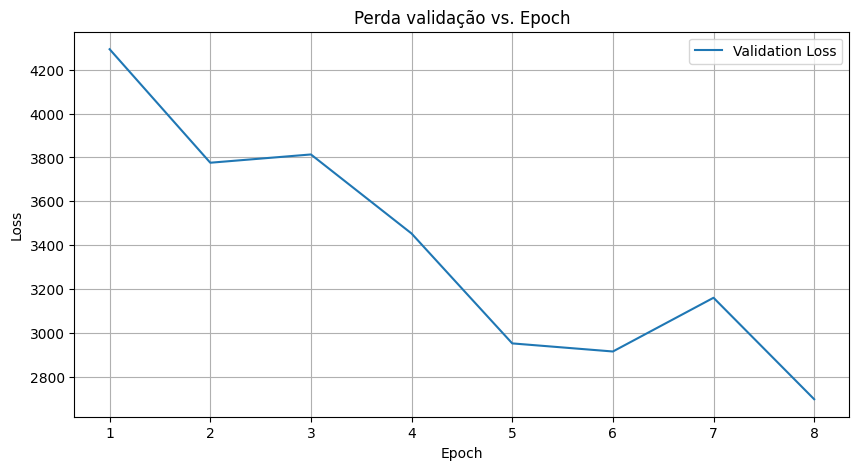

Epoch [9/30], Step [100/591], Loss: 0.5461
Epoch [9/30], Step [200/591], Loss: 0.4074
Epoch [9/30], Step [300/591], Loss: 0.6110
Epoch [9/30], Step [400/591], Loss: 0.7654
Epoch [9/30], Step [500/591], Loss: 0.3988
--------------------------------------------------------------------------
Epoch [9/30], Validation Accuracy: 84.06%
Epoch [9/30], Validation Precision: 0.84
Epoch [9/30], Validation Recall: 0.84
Epoch [9/30], Validation F1-score: 0.84


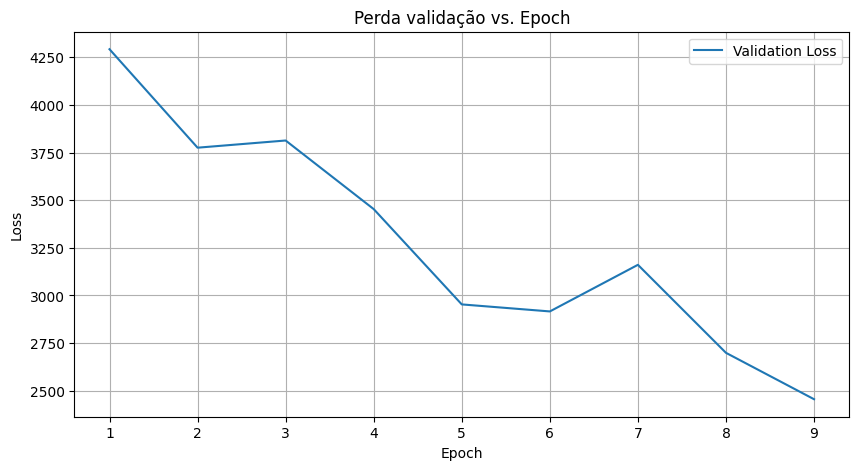

Epoch [10/30], Step [100/591], Loss: 0.7327
Epoch [10/30], Step [200/591], Loss: 0.5009
Epoch [10/30], Step [300/591], Loss: 0.8023
Epoch [10/30], Step [400/591], Loss: 0.4752
Epoch [10/30], Step [500/591], Loss: 0.2757
--------------------------------------------------------------------------
Epoch [10/30], Validation Accuracy: 85.00%
Epoch [10/30], Validation Precision: 0.85
Epoch [10/30], Validation Recall: 0.85
Epoch [10/30], Validation F1-score: 0.85


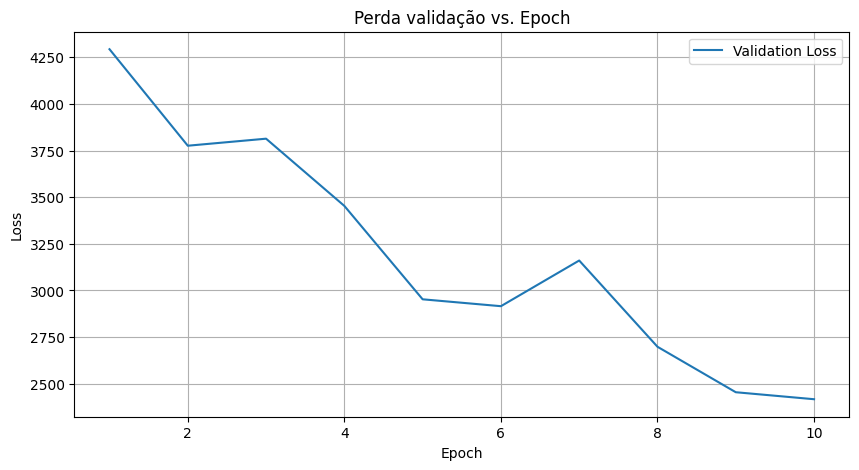

Epoch [11/30], Step [100/591], Loss: 0.5097
Epoch [11/30], Step [200/591], Loss: 0.8273
Epoch [11/30], Step [300/591], Loss: 0.3989
Epoch [11/30], Step [400/591], Loss: 0.3390
Epoch [11/30], Step [500/591], Loss: 0.6894
--------------------------------------------------------------------------
Epoch [11/30], Validation Accuracy: 86.35%
Epoch [11/30], Validation Precision: 0.86
Epoch [11/30], Validation Recall: 0.86
Epoch [11/30], Validation F1-score: 0.86


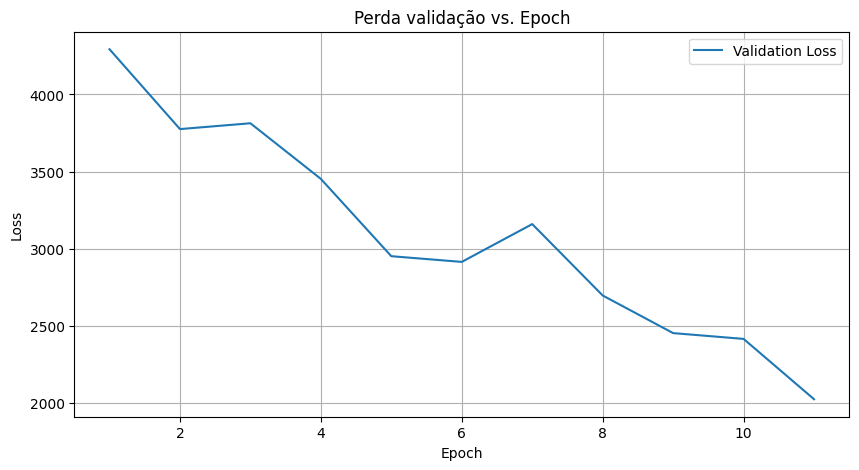

Epoch [12/30], Step [100/591], Loss: 0.4807
Epoch [12/30], Step [200/591], Loss: 0.4958
Epoch [12/30], Step [300/591], Loss: 0.5353
Epoch [12/30], Step [400/591], Loss: 0.5755
Epoch [12/30], Step [500/591], Loss: 0.5224
--------------------------------------------------------------------------
Epoch [12/30], Validation Accuracy: 83.11%
Epoch [12/30], Validation Precision: 0.84
Epoch [12/30], Validation Recall: 0.83
Epoch [12/30], Validation F1-score: 0.82


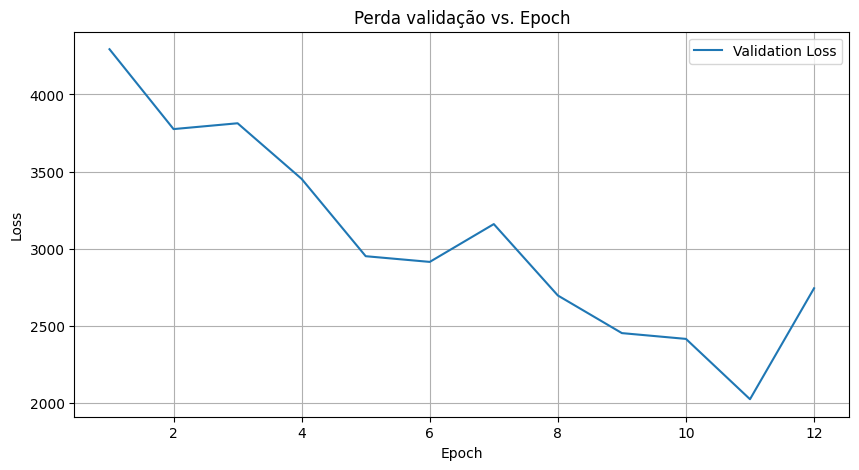

Epoch [13/30], Step [100/591], Loss: 0.4370
Epoch [13/30], Step [200/591], Loss: 0.4558
Epoch [13/30], Step [300/591], Loss: 0.2519
Epoch [13/30], Step [400/591], Loss: 0.5291
Epoch [13/30], Step [500/591], Loss: 0.8128
--------------------------------------------------------------------------
Epoch [13/30], Validation Accuracy: 86.69%
Epoch [13/30], Validation Precision: 0.86
Epoch [13/30], Validation Recall: 0.86
Epoch [13/30], Validation F1-score: 0.86


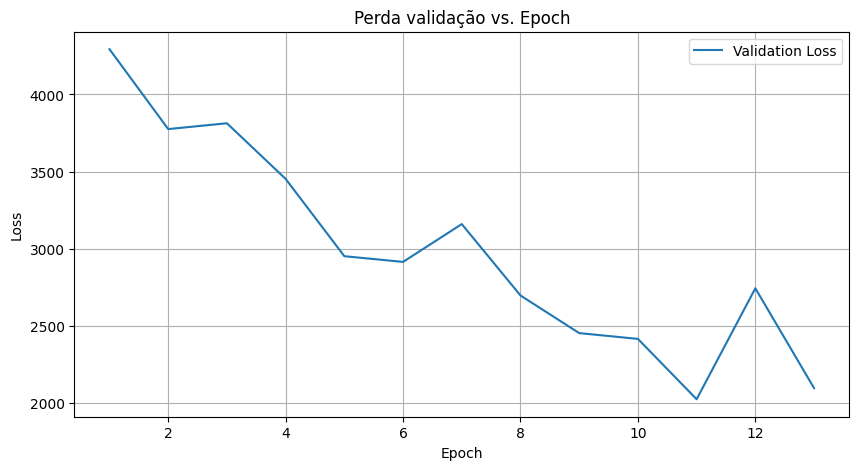

Epoch [14/30], Step [100/591], Loss: 0.5421
Epoch [14/30], Step [200/591], Loss: 0.5297
Epoch [14/30], Step [300/591], Loss: 0.2015
Epoch [14/30], Step [400/591], Loss: 0.2934
Epoch [14/30], Step [500/591], Loss: 0.3816
--------------------------------------------------------------------------
Epoch [14/30], Validation Accuracy: 86.83%
Epoch [14/30], Validation Precision: 0.87
Epoch [14/30], Validation Recall: 0.86
Epoch [14/30], Validation F1-score: 0.86


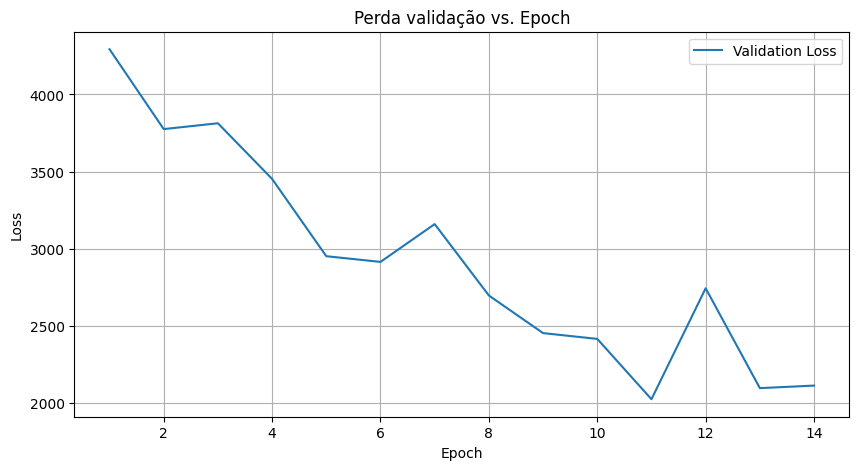

Epoch [15/30], Step [100/591], Loss: 0.3735
Epoch [15/30], Step [200/591], Loss: 0.6692
Epoch [15/30], Step [300/591], Loss: 0.7835
Epoch [15/30], Step [400/591], Loss: 0.2366
Epoch [15/30], Step [500/591], Loss: 0.2503
--------------------------------------------------------------------------
Epoch [15/30], Validation Accuracy: 86.96%
Epoch [15/30], Validation Precision: 0.87
Epoch [15/30], Validation Recall: 0.86
Epoch [15/30], Validation F1-score: 0.86


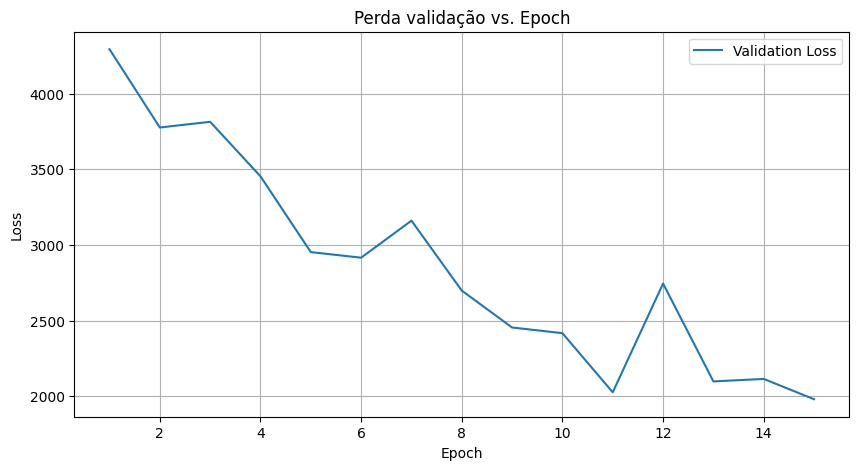

Epoch [16/30], Step [100/591], Loss: 0.3535
Epoch [16/30], Step [200/591], Loss: 0.3406
Epoch [16/30], Step [300/591], Loss: 0.6019
Epoch [16/30], Step [400/591], Loss: 0.4264
Epoch [16/30], Step [500/591], Loss: 0.3125
--------------------------------------------------------------------------
Epoch [16/30], Validation Accuracy: 87.15%
Epoch [16/30], Validation Precision: 0.87
Epoch [16/30], Validation Recall: 0.87
Epoch [16/30], Validation F1-score: 0.87


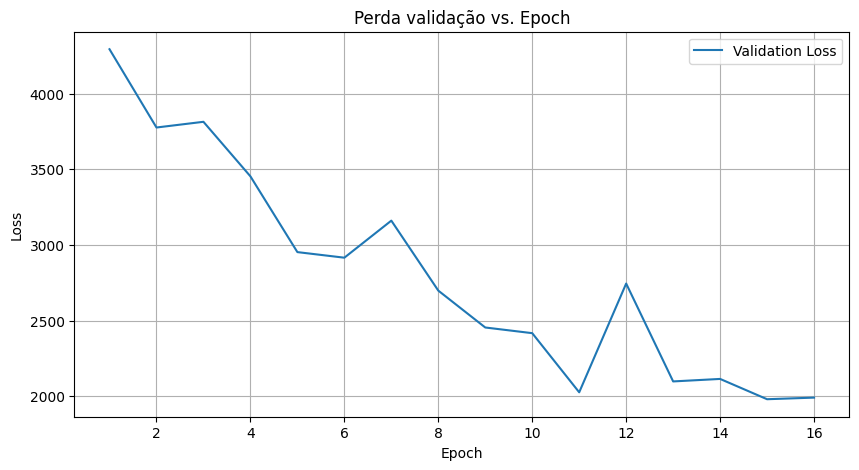

Epoch [17/30], Step [100/591], Loss: 0.8060
Epoch [17/30], Step [200/591], Loss: 0.3770
Epoch [17/30], Step [300/591], Loss: 0.8706
Epoch [17/30], Step [400/591], Loss: 0.3178
Epoch [17/30], Step [500/591], Loss: 0.3595
--------------------------------------------------------------------------
Epoch [17/30], Validation Accuracy: 87.85%
Epoch [17/30], Validation Precision: 0.88
Epoch [17/30], Validation Recall: 0.87
Epoch [17/30], Validation F1-score: 0.87


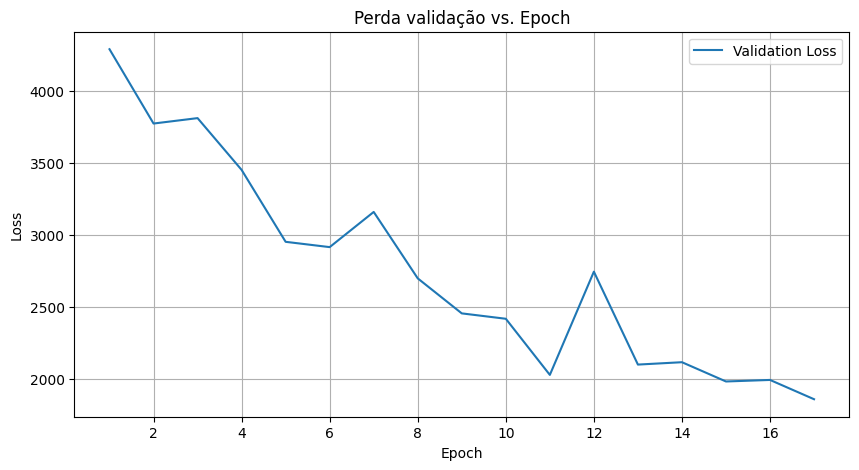

Epoch [18/30], Step [100/591], Loss: 0.2818
Epoch [18/30], Step [200/591], Loss: 0.7383
Epoch [18/30], Step [300/591], Loss: 0.5823
Epoch [18/30], Step [400/591], Loss: 0.6133
Epoch [18/30], Step [500/591], Loss: 0.3732
--------------------------------------------------------------------------
Epoch [18/30], Validation Accuracy: 86.20%
Epoch [18/30], Validation Precision: 0.86
Epoch [18/30], Validation Recall: 0.86
Epoch [18/30], Validation F1-score: 0.86


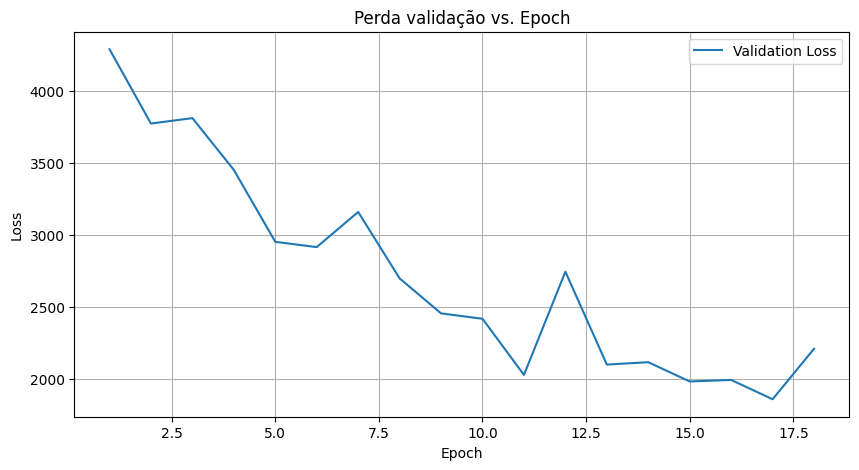

Epoch [19/30], Step [100/591], Loss: 0.2687
Epoch [19/30], Step [200/591], Loss: 0.5502
Epoch [19/30], Step [300/591], Loss: 0.6519
Epoch [19/30], Step [400/591], Loss: 0.5483
Epoch [19/30], Step [500/591], Loss: 0.5911
--------------------------------------------------------------------------
Epoch [19/30], Validation Accuracy: 88.20%
Epoch [19/30], Validation Precision: 0.88
Epoch [19/30], Validation Recall: 0.88
Epoch [19/30], Validation F1-score: 0.88


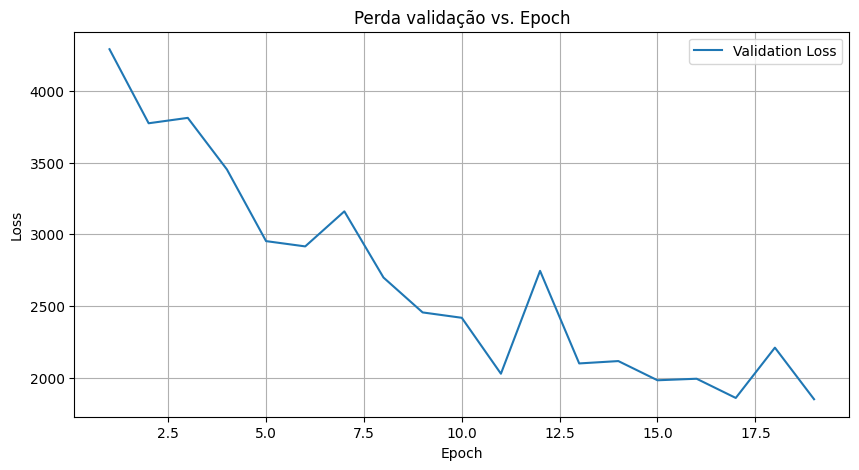

Epoch [20/30], Step [100/591], Loss: 0.3628
Epoch [20/30], Step [200/591], Loss: 0.8045
Epoch [20/30], Step [300/591], Loss: 0.3004
Epoch [20/30], Step [400/591], Loss: 0.4230
Epoch [20/30], Step [500/591], Loss: 0.3816
--------------------------------------------------------------------------
Epoch [20/30], Validation Accuracy: 87.81%
Epoch [20/30], Validation Precision: 0.88
Epoch [20/30], Validation Recall: 0.87
Epoch [20/30], Validation F1-score: 0.87


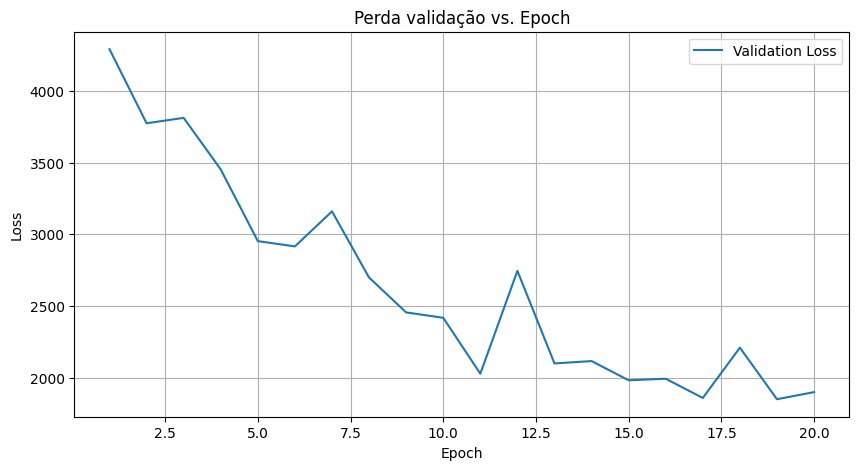

Epoch [21/30], Step [100/591], Loss: 1.0210
Epoch [21/30], Step [200/591], Loss: 0.3690
Epoch [21/30], Step [300/591], Loss: 0.2766
Epoch [21/30], Step [400/591], Loss: 0.3507
Epoch [21/30], Step [500/591], Loss: 0.4622
--------------------------------------------------------------------------
Epoch [21/30], Validation Accuracy: 88.17%
Epoch [21/30], Validation Precision: 0.88
Epoch [21/30], Validation Recall: 0.88
Epoch [21/30], Validation F1-score: 0.88


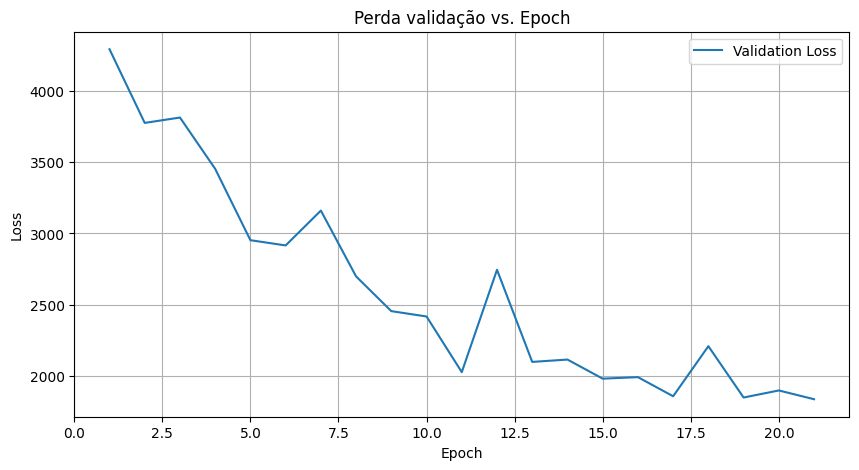

Epoch [22/30], Step [100/591], Loss: 0.1905
Epoch [22/30], Step [200/591], Loss: 0.4280
Epoch [22/30], Step [300/591], Loss: 0.2191
Epoch [22/30], Step [400/591], Loss: 0.4877
Epoch [22/30], Step [500/591], Loss: 0.3404
--------------------------------------------------------------------------
Epoch [22/30], Validation Accuracy: 88.67%
Epoch [22/30], Validation Precision: 0.88
Epoch [22/30], Validation Recall: 0.88
Epoch [22/30], Validation F1-score: 0.88


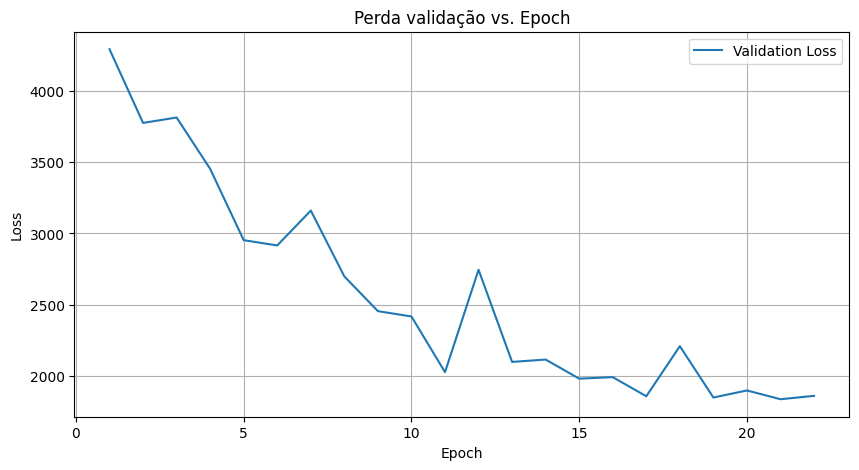

Epoch [23/30], Step [100/591], Loss: 0.1427
Epoch [23/30], Step [200/591], Loss: 0.5837
Epoch [23/30], Step [300/591], Loss: 0.3425
Epoch [23/30], Step [400/591], Loss: 0.3698
Epoch [23/30], Step [500/591], Loss: 0.2882
--------------------------------------------------------------------------
Epoch [23/30], Validation Accuracy: 89.80%
Epoch [23/30], Validation Precision: 0.90
Epoch [23/30], Validation Recall: 0.89
Epoch [23/30], Validation F1-score: 0.89


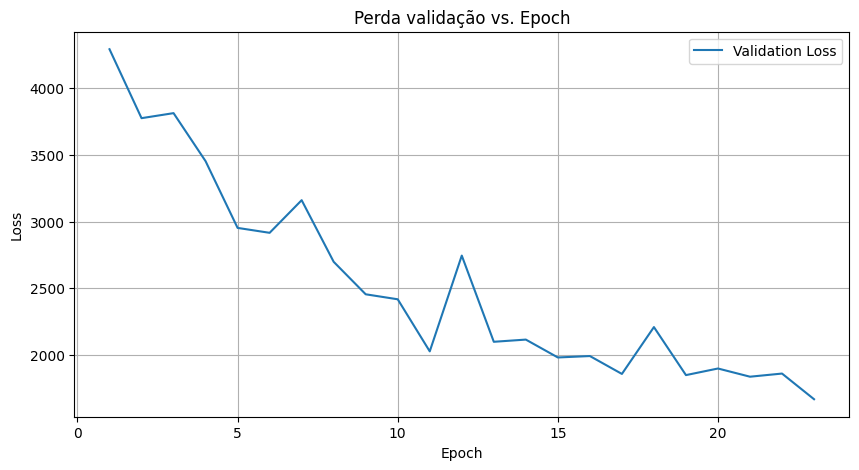

Epoch [24/30], Step [100/591], Loss: 0.2952
Epoch [24/30], Step [200/591], Loss: 0.5183
Epoch [24/30], Step [300/591], Loss: 0.3049
Epoch [24/30], Step [400/591], Loss: 0.6155
Epoch [24/30], Step [500/591], Loss: 0.5080
--------------------------------------------------------------------------
Epoch [24/30], Validation Accuracy: 88.83%
Epoch [24/30], Validation Precision: 0.89
Epoch [24/30], Validation Recall: 0.89
Epoch [24/30], Validation F1-score: 0.88


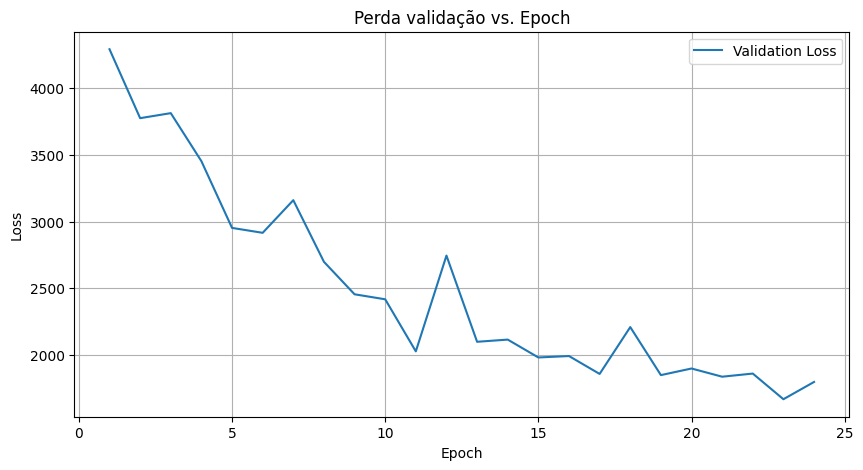

Epoch [25/30], Step [100/591], Loss: 0.4859
Epoch [25/30], Step [200/591], Loss: 0.2759
Epoch [25/30], Step [300/591], Loss: 0.3574
Epoch [25/30], Step [400/591], Loss: 0.2451
Epoch [25/30], Step [500/591], Loss: 0.2382
--------------------------------------------------------------------------
Epoch [25/30], Validation Accuracy: 89.63%
Epoch [25/30], Validation Precision: 0.89
Epoch [25/30], Validation Recall: 0.90
Epoch [25/30], Validation F1-score: 0.89


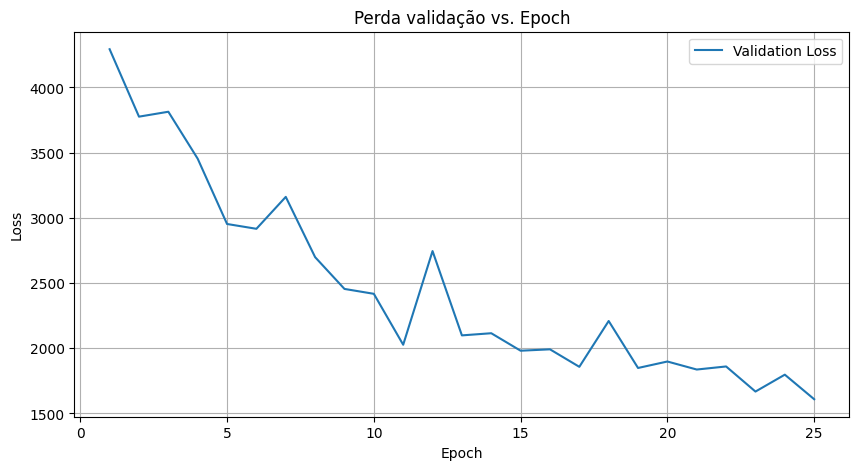

Epoch [26/30], Step [100/591], Loss: 0.6101
Epoch [26/30], Step [200/591], Loss: 0.2957
Epoch [26/30], Step [300/591], Loss: 0.4142
Epoch [26/30], Step [400/591], Loss: 0.4936
Epoch [26/30], Step [500/591], Loss: 0.3020
--------------------------------------------------------------------------
Epoch [26/30], Validation Accuracy: 89.76%
Epoch [26/30], Validation Precision: 0.90
Epoch [26/30], Validation Recall: 0.89
Epoch [26/30], Validation F1-score: 0.89


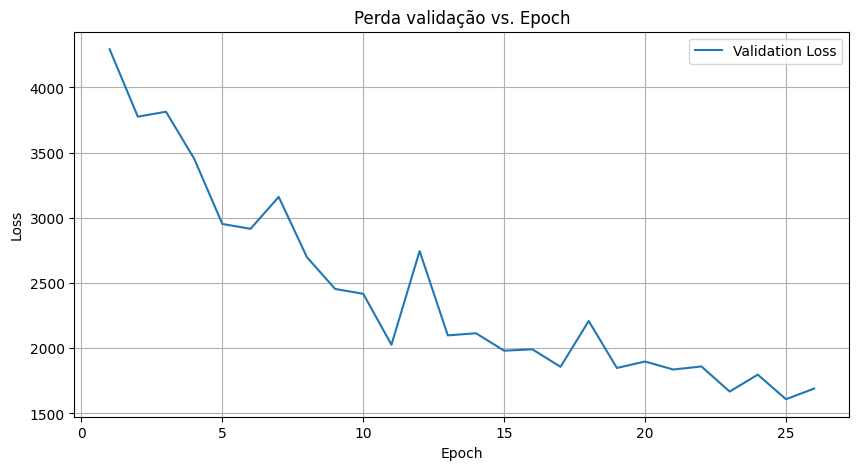

----------------------------------------------------
-----------------Early stopping---------------------
>> depois de: 26 epochs.
----------------------------------------------------
Acurácia de validação máxima: 89.76%


In [ ]:
# ---- parâmetros treino
num_epochs = 30  # Número máximo de épocas
patience = 3  # Número de épocas para esperar por melhoria
best_val_accuracy = 0
epochs_no_improve = 0

# ---- parâmetros plotagem
epoch_list = []
loss_list = []

# ---- primeiro loop que itera (epochs) para o modelo aprender com o DataSet
for epoch in range(num_epochs):
    # Parte I Treinamento
    model.train()  # Define o modelo para modo de treinamento
    for i, (images, labels) in enumerate(train_loader): # retorna index i, images e labels
        images = images.to(device) # move os dados para a GPU
        labels = labels.to(device) # move os labels para a GPU

        outputs = model(images) # passa as images para o modelo obter predições
        loss = criterion(outputs, labels) # calcula a perda

        optimizer.zero_grad() # zera os gradientes antes de novo passo
        loss.backward() # computa os gradientes usando backpropagation
        optimizer.step() # atualiza os parâmetros do otimizador e calcula gradientes

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # Parte II Validação
    model.eval()
    all_predictions = []
    all_labels = []
    correct = 0
    total = 0
    val_loss = 0.0 # inicializa perda

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels) # calcula perda
            val_loss += loss.item() * images.size(0) # acumula perda
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

#    val_loss = val_loss / len(val_loader.dataset) # média da perda
#    val_losses.append(val_loss) # append na lista

    # Impressão acompanhamento de acurácia, precisão, recall e F1-Score
    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)

    print("--------------------------------------------------------------------------")
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Accuracy: {accuracy:.2f}%')
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Precision: {precision:.2f}')
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Recall: {recall:.2f}')
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation F1-score: {f1:.2f}')

    # Plotting (para acompanhamento)

    epoch_list.append(epoch + 1)
    loss_list.append(val_loss) # Assuming val_loss is calculated correctly

    plt.figure(figsize=(10, 5))  # Adjust figure size for better visualization
    plt.plot(epoch_list, loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Perda validação vs. Epoch') # Added a title
    plt.legend()
    plt.grid(True) # Added grid for better readability
    plt.show()

    # Early stopping
    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("----------------------------------------------------")
            print("-----------------Early stopping---------------------")
            print(f'>> depois de: {epoch + 1} epochs.')
            print("----------------------------------------------------")
            print(f'Acurácia de validação máxima: {accuracy:.2f}%')
            break


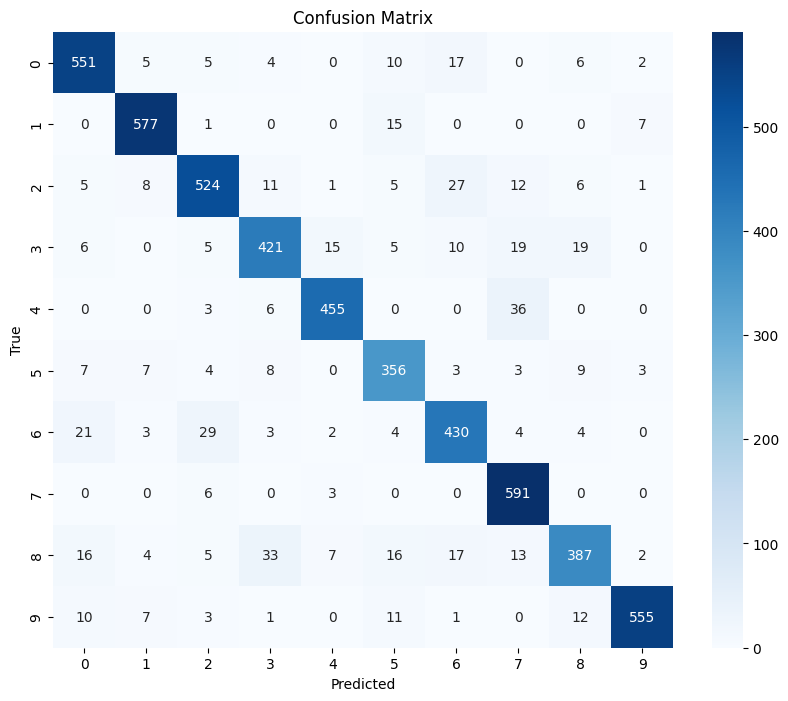

In [ ]:
#@title Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



# 5 Avaliação do Modelo

In [ ]:
#@title Avaliação do Modelo no conjunto de teste

model.eval()  # Define o modelo para o modo de avaliação
with torch.no_grad():  # Desativa o cálculo do gradiente
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Acurácia do Modelo no conjunto de testes: {100 * correct / total}%')

Acurácia do Modelo no conjunto de testes: 89.81481481481481%
